# 08. Pytorch paper - Vision Transformer



## 0. Get Setup


In [45]:
# For notebook to run with updated API's, we need torch 1.12+ and torchvision 0.13+
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[0]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://download.pytorch.org/whl/cu118
torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [86]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it does not work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from github if it does not work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going modular scripts
  print("[INFO] Couldn't find going_modular or helperfunctions scripts... downloading them from github.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep_learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

### 1. Get Data

In [87]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [88]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [89]:
### 2. Create Datasets and DataLoaders

## 2.1 Prepare transforms for images
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)
Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [90]:
## 2.2 Turn image into DataLoader's
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78879e234410>,
 ['pizza', 'steak', 'sushi'])

(<torch.utils.data.dataloader.DataLoader at 0x78879f9d5d30>,
 ['pizza', 'steak', 'sushi'])

In [91]:
## 2.3 Visualize a single image

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(torch.Size([3, 224, 224]), tensor(1))

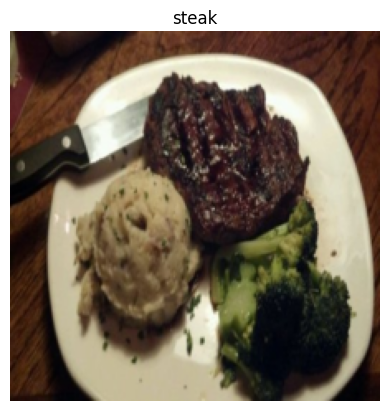

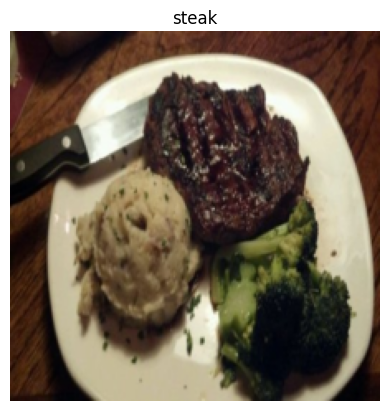

In [92]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

### 4.1 Calculate patch embedding input and output shapes


In [93]:
height = 224
width  = 224
color_channels = 3
patch_size = 16

# Calculate N (number of patches)
number_of_patches = (height * width) / (patch_size * patch_size)
print(f"Number of patches: {number_of_patches}")

Number of patches: 196.0
Number of patches: 196.0


* Input: The image starts as 2D with size ${H \times W \times C}$.
* Output: The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [94]:
# Input Shape ( this is the size of single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output Shape
embedding_layer_output_shape = (number_of_patches, patch_size * patch_size * color_channels)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196.0, 768))

((224, 224, 3), (196.0, 768))

### 4.2 Turning single image into patches


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

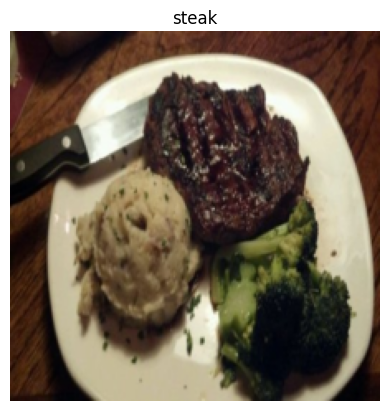

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

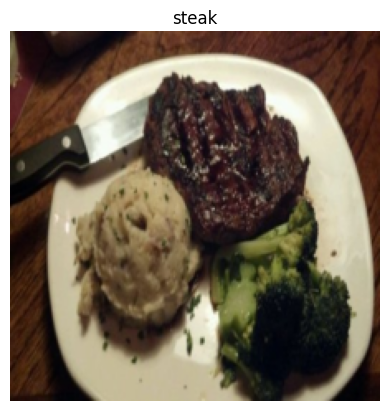

In [95]:
# View  a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [96]:
image.shape

torch.Size([3, 224, 224])

torch.Size([3, 224, 224])

(np.float64(-0.5), np.float64(223.5), np.float64(15.5), np.float64(-0.5))

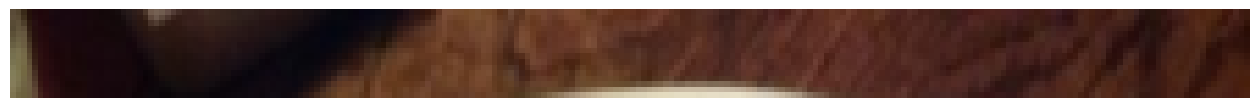

(np.float64(-0.5), np.float64(223.5), np.float64(15.5), np.float64(-0.5))

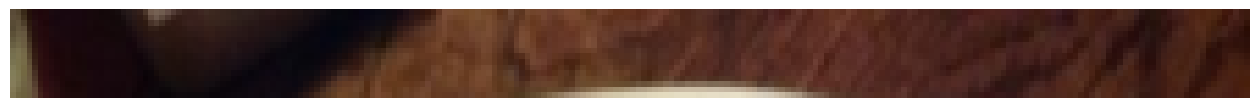

In [97]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # Convert the image into color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:, :])
plt.axis(False)

Number of patches: 14.0


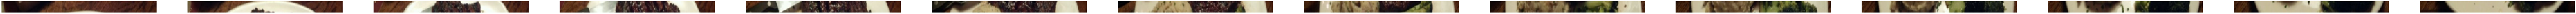

Number of patches: 14.0


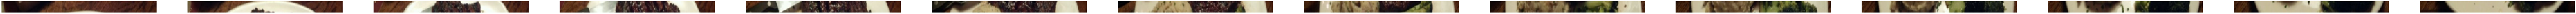

In [98]:
# Set up code to plot top row as patches
img_size = 224
patch_size = 16
number_of_patches = img_size/patch_size
print(f"Number of patches: {number_of_patches}")
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# Create a series of sub plots
fig, axs = plt.subplots(nrows= 1,
                        ncols= img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(img_size, img_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].axis(False)

In [59]:
import matplotlib.pyplot as plt


# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches: {num_patches}\
      \nNumber of rows: {num_patches}\
      \nNumber of columns: {num_patches}\
      \nImage size: {img_size}\
      \nPatch size: {patch_size}\
      \nTotal Patches : {num_patches ** 2}")

# Create a series of patches
fig, axs = plt.subplots(nrows= int(num_patches),
                        ncols= int(num_patches),
                        sharex=True,
                        sharey=True,
                        figsize=(img_size, img_size))

# Loop through height and width of image
for i, patch_row in enumerate(range(0, img_size, patch_size)):
  for j, patch_col in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_row:patch_row+patch_size, patch_col:patch_col+patch_size])
    axs[i, j].set_ylabel(i+1,
                         rotation = "horizontal",
                         horizontalalignment = "right",
                         verticalalignment = "center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].axis(False)
    axs[i, j].label_outer()

Number of patches: 14.0      
Number of rows: 14.0      
Number of columns: 14.0      
Image size: 224      
Patch size: 16      
Total Patches : 196.0


### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using 'torch.nn.Conv2d' layer and setting kernel size and stride nn.parameter to 'patch_size'

In [60]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

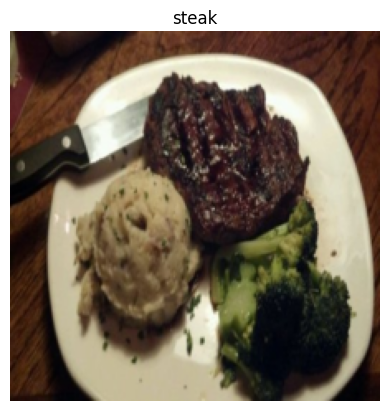

In [61]:
# View Single Image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [62]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Now we have passed our single image to out 'conv2d' layer, it's shape is :

```python
torch.Size([1, 768, 14, 14])
```

In [63]:
image_out_of_conv.requires_grad

True

Random indexes: [19, 8, 97, 174, 114]


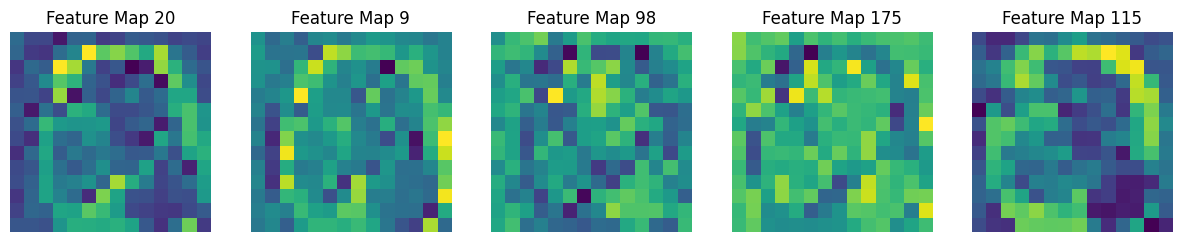

In [64]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Random indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        sharex=True,
                        sharey=True,
                        figsize=(15, 5))
# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[0, idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set_title(f"Feature Map {idx+1}")
  axs[i].axis(False)

In [65]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad, single_feature_map.shape

(tensor([[[-0.1432, -0.0223, -0.0256, -0.0164, -0.1802, -0.1620, -0.1996,
           -0.2507, -0.2751, -0.1207, -0.0810, -0.0837, -0.0833, -0.0846],
          [-0.1429, -0.0511, -0.0682, -0.1589, -0.4220, -0.7673, -0.2521,
           -0.3645, -0.4556, -0.5096, -0.5387, -0.2598, -0.1019, -0.1013],
          [-0.1146, -0.1725, -0.0390, -0.5398, -0.4770, -0.2057, -0.0908,
           -0.0930,  0.1815,  0.1409, -0.5223, -0.4485, -0.0993, -0.1112],
          [-0.1375, -0.1301, -0.0874, -0.4645, -0.4408, -0.0259,  0.0614,
           -0.1792, -0.1387, -0.1444,  0.0367, -0.4870, -0.5066, -0.0540],
          [-0.1099, -0.0963, -0.1740, -0.3990, -0.1991, -0.0957, -0.2298,
           -0.0384, -0.1772, -0.0895, -0.1279, -0.3692, -0.3950, -0.0841],
          [-0.0434,  0.0980, -0.1920, -0.3759, -0.4621, -0.4181, -0.0955,
           -0.0879, -0.1063, -0.0724, -0.1280, -0.3396, -0.4670, -0.3001],
          [-0.1127, -0.2132, -0.4468, -0.2846, -0.2983, -0.3445, -0.3365,
           -0.1943, -0.0454, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we got a series of convolutional feature maps(patch embeddings that we want to flatten into a sequence of patch embeddings to satisfy the criteria of the ViT Transformer Encoder.

In [66]:
print(f"{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


In [67]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=-1)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image shape after conv2d layer: torch.Size([1, 768, 14, 14])
Image shape after flatten layer: torch.Size([1, 768, 196])


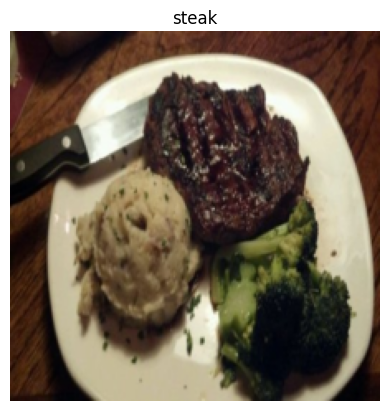

In [68]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into features
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
print(f"Image shape after conv2d layer: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_flatten = flatten_layer(image_out_of_conv)
print(f"Image shape after flatten layer: {image_out_of_flatten.shape}")

In [69]:
# Rearrange output of lfattened layer
image_out_of_flatten = image_out_of_flatten.permute(0, 2, 1)
print(f"{image_out_of_flatten.shape} -> (batch_size, number_of_patches, embedding_dim)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim)


In [70]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_flatten[:, :, 0]
single_flattened_feature_map, single_flattened_feature_map.shape

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis(False)

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

In [71]:
# Check the shape of the tensor after flattening and permuting
print(f"Shape of image_out_of_flatten after flattening and permuting: {image_out_of_flatten.shape}")

Shape of image_out_of_flatten after flattening and permuting: torch.Size([1, 196, 768])


### 4.5 Turning the ViT patch embedding layer into a Pytorch module

We want this module to do a few things
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embeddings dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define ` forward()` that defines the forward computation (e.g., pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [72]:
# 1. Create a class called Patch Embedding
class PatchEmbedding(nn.Module):
  #2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels: int = 3,
               embedding_dim: int = 768,
               patch_size: int = 16):
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    self.embedding_dim = embedding_dim
    self.patch_size = patch_size

  #3. Create a layer to turn an image into embedding patches using nn.Conv2d()
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Image size must be divisible by patch size, image shape : {image_resolution}, patch size: {self.patch_size}"
    # Pass image through convolutional layer
    x_out = self.patcher(x)
    x_out = self.flatten(x_out)
    x_out = x_out.permute(0, 2, 1)
    return x_out


set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          embedding_dim=768,
                          patch_size=16)
# Pass a single image through patch embedding layer
print(f"Input shape: {image.shape}")
print(f"Output shape: {patchify(image.unsqueeze(dim=0)).shape}")
print(f"Output patch embedding sequence shape : {patchify(image.unsqueeze(dim=0))[:, :, 0]}")

Input shape: torch.Size([3, 224, 224])
Output shape: torch.Size([1, 196, 768])
Output patch embedding sequence shape : tensor([[-0.0406, -0.0984, -0.0985, -0.1319, -0.3497, -0.3424, -0.3980, -0.3611,
         -0.3869, -0.2603, -0.2204, -0.2237, -0.1540, -0.2188, -0.1325, -0.1111,
         -0.2212, -0.6067, -0.5872, -0.8518, -0.9738, -0.8128, -0.9090, -0.9301,
         -0.5429, -0.2918, -0.2324, -0.1968, -0.2647, -0.3660, -0.5785, -1.1664,
         -0.8450, -0.2501, -0.2453, -0.1268, -0.2198, -0.6741, -0.9446, -0.9065,
         -0.2005, -0.2180, -0.3131, -0.2487, -0.8028, -0.9386, -0.7429, -0.1236,
         -0.2609, -0.2978, -0.1082, -0.1592, -0.7309, -0.9263, -0.1818, -0.2068,
         -0.1592, -0.1445, -0.2897, -0.8443, -0.3732, -0.2085, -0.1925, -0.2996,
         -0.2981, -0.1503, -0.2420, -0.8476, -0.7818, -0.2384, -0.1670, -0.4360,
         -0.3111, -0.3400, -0.7304, -0.4372, -0.2185, -0.1961, -0.2807, -0.2453,
         -0.2015, -1.0566, -0.8655, -0.0471, -0.2080, -0.6278, -0.7954,

In [73]:
rand_image_tensor = torch.randn(1,3,224, 224)
rand_image_tensor_bad = torch.randn(1,3,229, 229)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patchify(rand_image_tensor).shape}")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 196, 768])


### 4.6 Creating the class token embedding
Want to : prepend a learnable class token to the start of the patch embedding

In [74]:
patch_embedded_image = patchify(image.unsqueeze(dim=0))
patch_embedded_image

tensor([[[-4.0553e-02, -7.2474e-02, -8.3694e-02,  ..., -2.6024e-02,
          -5.9280e-02,  1.8236e-01],
         [-9.8427e-02,  3.1901e-02, -2.6524e-02,  ...,  9.4011e-02,
          -5.3517e-02, -5.1324e-03],
         [-9.8546e-02,  6.3031e-03, -3.2636e-02,  ...,  5.5722e-02,
          -4.9573e-02,  4.0111e-02],
         ...,
         [-3.5694e-01,  6.3352e-02, -3.9137e-01,  ...,  4.1906e-01,
          -3.5457e-04,  2.2769e-01],
         [-5.7191e-01,  4.3140e-02, -1.9199e-02,  ...,  1.2175e-01,
           1.2809e-03,  2.9564e-01],
         [-6.8749e-02, -4.5545e-03, -2.3688e-02,  ...,  5.4381e-02,
          -4.1440e-02, -2.7557e-02]]], grad_fn=<PermuteBackward0>)

In [75]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[2]
batch_size, embedding_dim

(1, 768)

In [76]:
# Create a class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [77]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-4.0553e-02, -7.2474e-02, -8.3694e-02,  ..., -2.6024e-02,
          -5.9280e-02,  1.8236e-01],
         [-9.8427e-02,  3.1901e-02, -2.6524e-02,  ...,  9.4011e-02,
          -5.3517e-02, -5.1324e-03],
         ...,
         [-3.5694e-01,  6.3352e-02, -3.9137e-01,  ...,  4.1906e-01,
          -3.5457e-04,  2.2769e-01],
         [-5.7191e-01,  4.3140e-02, -1.9199e-02,  ...,  1.2175e-01,
           1.2809e-03,  2.9564e-01],
         [-6.8749e-02, -4.5545e-03, -2.3688e-02,  ...,  5.4381e-02,
          -4.1440e-02, -2.7557e-02]]], grad_fn=<CatBackward0>)

### 4.7 Creating the position embedding
Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [78]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [-4.0553e-02, -7.2474e-02, -8.3694e-02,  ..., -2.6024e-02,
           -5.9280e-02,  1.8236e-01],
          [-9.8427e-02,  3.1901e-02, -2.6524e-02,  ...,  9.4011e-02,
           -5.3517e-02, -5.1324e-03],
          ...,
          [-3.5694e-01,  6.3352e-02, -3.9137e-01,  ...,  4.1906e-01,
           -3.5457e-04,  2.2769e-01],
          [-5.7191e-01,  4.3140e-02, -1.9199e-02,  ...,  1.2175e-01,
            1.2809e-03,  2.9564e-01],
          [-6.8749e-02, -4.5545e-03, -2.3688e-02,  ...,  5.4381e-02,
           -4.1440e-02, -2.7557e-02]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [79]:
# Calculate the N ( number of patches)
number_of_patches = int((height * width) / (patch_size * patch_size))

# Get the embedding dimension
embedding_dim = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,      embedding_dim),
                                  requires_grad=True)
position_embedding


Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)

In [80]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Shape of patch and position embedding: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9594, 0.9275, 0.9163,  ..., 0.9740, 0.9407, 1.1824],
         [0.9016, 1.0319, 0.9735,  ..., 1.0940, 0.9465, 0.9949],
         ...,
         [0.6431, 1.0634, 0.6086,  ..., 1.4191, 0.9996, 1.2277],
         [0.4281, 1.0431, 0.9808,  ..., 1.1217, 1.0013, 1.2956],
         [0.9313, 0.9954, 0.9763,  ..., 1.0544, 0.9586, 0.9724]]],
       grad_fn=<AddBackward0>)
Shape of patch and position embedding: torch.Size([1, 197, 768])


### 4.8 Putting it all together : from image to embedding
We've written code to turn a single image into a sequence of patch embeddings.
Lets write in one cell

In [81]:
# Set seeds
set_seeds()
# 1. Set Patch size
patch_size = 16

# 2. Print shapes of original tensor shape and get the image dimensions
print(f"Image tensor shape: {image.shape}")
image_resolution = image.shape[-1]
print(f"Image resolution: {image_resolution}")

# 3. Get the image tensor and add a batch dimension
image_tensor = image.unsqueeze(dim=0)
print(f"Image tensor shape: {image_tensor.shape}")

# 4. Create a patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          embedding_dim=768,
                          patch_size=patch_size)
print(f"Patch embedding layer: {patchify}")

# 5. Pass input image through Patch Embedding LAyer
patch_embedded_image = patchify(image_tensor)
print(f"Shape of patch embedded image: {patch_embedded_image.shape}")

# 6. Create a class token embeddings
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[2]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)

# 7. Prepend the class token embedding to the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
print(f"Shape of patch embedded image with class embedding: {patch_embedded_image_with_class_embedding.shape}")

# 8. Create patch position embedding
number_of_patches = int((image_resolution * image_resolution) / (patch_size * patch_size))
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,      embedding_dim),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with the class token
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(f"Shape of patch and position embedding: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Image resolution: 224
Image tensor shape: torch.Size([1, 3, 224, 224])
Patch embedding layer: PatchEmbedding(
  (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=2, end_dim=3)
)
Shape of patch embedded image: torch.Size([1, 196, 768])
Shape of patch embedded image with class embedding: torch.Size([1, 197, 768])
Shape of patch and position embedding: torch.Size([1, 197, 768])


## Equation 2: Multi head self attention

* Multi head self attention: which part of a sequence should pay the most attention to itself?
  * In our case, we have a series of embedded image patches, which patch significantly relates to another patch
  * We want our neural network (ViT) to learn this relationship/representation.
* To replicate MSA in Pytorch we can use https://docs.pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm = Layer Normalization(LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.
  * In Pytorch - https://docs.pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html normalizes values over $D$ dimension, in our case, the $D$ is the embedding dimension.
    * When we normalize along the embedding dimension,it's like making all of the stairs in a staircase the same size.
    


In [82]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """ Creates a multi-head self-attention block ("MSA block" for short)
  """
  def __init__(self,
             embedding_dim:int=768, # Hidden size D (embedding dimension) from Table
             num_heads:int = 12, # Heads from Table 1 for ViT Base
             attn_dropout:int = 0 # Dropout from Table 1 for ViT Base
             ):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead self attention(MSA) layer
    self.multihead_self_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                         num_heads=num_heads,
                                                         dropout=attn_dropout)
        #is the batch first? (batch,number_of_patches, embedding_dimenstion)
  def forward(self, x):
    x = self.layer_norm(x)
    x, _ = self.multihead_self_attention(query=x,
                                    key=x,
                                    value=x)
    return x

In [83]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                            num_heads=12,
                                                            attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA Block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)

print(f"Shape of patched image through MSA block: {patched_image_through_msa_block.shape}")
print(f"Shape of patch and position embedding: {patch_and_position_embedding.shape}")



Shape of patched image through MSA block: torch.Size([1, 197, 768])
Shape of patch and position embedding: torch.Size([1, 197, 768])


### Equation 3 : MLP Block
* **MLP** = The MLP contains two layers with a GELU non- linearity (section 3.1)
  * MLP = a quite broad term for a block with a series of layers, layers can be multiple or even only one hidden layer.
  * Layers can mean: fully connected, dense, linear, feed forward, all are often similar names for the same thing. In Pytorch, they have often called torch.nn.Linear() and in TensorFlow they might be called tf.keras.layers.Dense()
  * GELU in Pytorch - https://docs.pytorch.org/docs/stable/generated/torch.nn.GELU.html
  * **Dropout** = Dropout, when used, is applied after every dense layer except for the qkv- projections and directly after adding positional - to patch embeddings. Hybrid models are trained with the exact setup as their ViT counterparts.

  In pseudocode:
  ```python
  # MLP
  x = linear -> non-linear -> dropout ->linear -> dropout
  ```
  


In [84]:
from torch import nn

class MLPBlock(nn.Module):
  """Creates a multi-layer perceptron block
  """
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:float=0.1):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features = embedding_dim),
        nn.Dropout(p=dropout)

    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [99]:
# Create an instance of MLP Block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
# Pass the output of the MSA block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)

print(f"Shape of patched image through MLP block: {patched_image_through_mlp_block.shape}")

Shape of patched image through MLP block: torch.Size([1, 197, 768])
Shape of patched image through MLP block: torch.Size([1, 197, 768])
